# **零，連接Google Drive並設定工作目錄**

In [1]:
# Mask R-CNN reference code
# https://www.cnblogs.com/hellcat/p/9987442.html


# the reference web of Colab with google drive : https://www.jianshu.com/p/ce2e63d1c10c
# 戴入檔案的方式， 
# COLAB  0:從Local端的路徑  
#        1:從Google Drive 中載入 

import os
import pandas as pd
import numpy as np
import datetime
import os.path as path


IS_COLAB = 1

if IS_COLAB == 1:
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p drive
  !google-drive-ocamlfuse drive

  # 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
  os.chdir("drive/Colab Notebooks/ice berg") 
  !ls

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.4-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

# **一、 載入訓練資料並查看訓練資料的格式與內容**

In [2]:
import gc
IS_ENABLE_NORMALIZATION = True

train_data = pd.read_json("train.json")
print ("=== basic data information ===")
print (train_data.info())

print ("=== filter out the 'na' value of angle field  ===")
train_data = train_data[train_data["inc_angle"] != 'na'] 
print ("the number of train data : ", len(train_data))
iceberg_data = train_data[train_data["is_iceberg"] == 1]
print ("the number of iceberg on train data : ", len(iceberg_data))
non_iceberg_data = train_data[train_data["is_iceberg"] == 0]
print ("the number of non-iceberg on train data : ", len(non_iceberg_data))

train_dataset = iceberg_data[0:636]
train_dataset = train_dataset.append(non_iceberg_data[0:635])
print ("the number of train dataset : ", len (train_dataset))
valid_dataset = iceberg_data[636:]
valid_dataset = valid_dataset.append(non_iceberg_data[635:])
print ("the number of valid dataset : ", len (valid_dataset))
train_data.head()

del train_data
del iceberg_data
del non_iceberg_data
gc.collect()

=== basic data information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB
None
=== filter out the 'na' value of angle field  ===
the number of train data :  1471
the number of iceberg on train data :  753
the number of non-iceberg on train data :  718
the number of train dataset :  1271
the number of valid dataset :  200


7

In [3]:
test_data = pd.read_json("test.json")
print ("=== basic data information ===")
print (test_data.info())

print ("=== filter out the 'na' value of angle field  ===")
test_data = test_data[test_data["inc_angle"] != 'na']

print ("the count of train data : ", len(test_data))
 
test_data.head()

=== basic data information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 4 columns):
band_1       8424 non-null object
band_2       8424 non-null object
id           8424 non-null object
inc_angle    8424 non-null float64
dtypes: float64(1), object(3)
memory usage: 263.3+ KB
None
=== filter out the 'na' value of angle field  ===
the count of train data :  8424


/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


# **二、對訓練資料集的Band 1 及Band 2 進行資料的預處理**

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, gc, psutil

IMAGE_WIDTH = 75 
IMAGE_HEIGHT = 75
DISPLAY_IMAGE = 7

def display_ice_berg(band_1, band_2, angle, is_iceberg=None, index_base=0 , suptitle = "display data image"): 
  
  fig, ax = plt.subplots(figsize=(22 , 6))
  fig.subplots_adjust(hspace=0.4, wspace=0.1)
  for i in range(DISPLAY_IMAGE):   
    plt.subplot(2, DISPLAY_IMAGE, i +1)
    if is_iceberg is None:
      plt.title("band 1 : {}".format(round(angle[i+index_base][0],8)))
    else:
      plt.title("band 1 : {}-{}".format(is_iceberg[i+index_base][0], round(angle[i+index_base][0],8)))
    plt.axis("off")
    plt.imshow(band_1[i + index_base].reshape(75,75), cmap="gray")
   
  for i in range(DISPLAY_IMAGE):     
    plt.subplot(2, DISPLAY_IMAGE, i + DISPLAY_IMAGE + 1)
    if is_iceberg is None:
      plt.title("band 2 : {}".format(round(angle[i+index_base][0],8)))
    else:
      plt.title("band 2 : {}-{}".format(is_iceberg[i+index_base][0], round(angle[i+index_base][0],8))) 
    plt.axis("off") 
    plt.suptitle(suptitle)    
    plt.imshow(band_2[i + index_base].reshape(75,75), cmap="gray")

def normalization_data(band_1, band_2, angle, is_enable):
  if is_enable:
    band_1 = (band_1 + 128) /256
    band_2 = (band_2 + 128) /256
    angle = angle /180
  return band_1, band_2, angle

=== Train Dataset ===
band 1 shape : (1271, 75, 75, 1)
band 2 shape : (1271, 75, 75, 1)
angle shape : (1271, 1)
is_iceberg shape : (1271, 1)
=== Test Dataset ===
band 1 shape : (200, 75, 75, 1)
band 2 shape : (200, 75, 75, 1)
angle shape : (200, 1)
is_iceberg shape : (200, 1)


1028

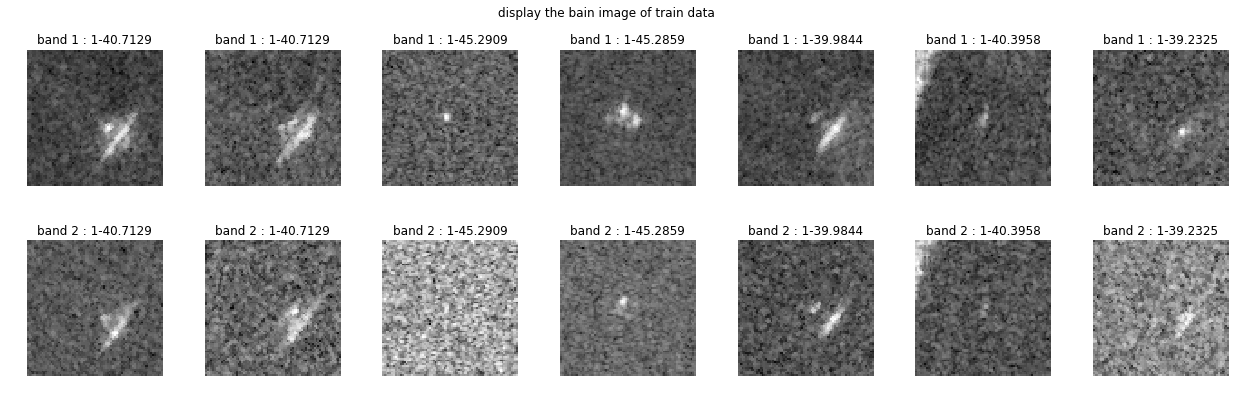

In [5]:
# Train Data Band 1 and Band 2 Image
import gc 
print ("=== Train Dataset ===")
band_1_train_data = np.array([np.array(data).astype(np.float32).reshape(75, 75, 1) for data in train_dataset['band_1']])
print ("band 1 shape :", band_1_train_data.shape)
band_2_train_data = np.array([np.array(data).astype(np.float32).reshape(75, 75, 1) for data in train_dataset['band_2']])
print ("band 2 shape :", band_2_train_data.shape)
angle_train_data = np.array(train_dataset['inc_angle']).reshape(-1, 1)
print ("angle shape :", angle_train_data.shape)
is_iceberg_train_data = np.array(train_dataset["is_iceberg"]).reshape(-1, 1)
print ("is_iceberg shape :", is_iceberg_train_data.shape)

print ("=== Test Dataset ===")  
band_1_valid_data = np.array([np.array(data).astype(np.float32).reshape(75, 75, 1) for data in valid_dataset['band_1']])
print ("band 1 shape :", band_1_valid_data.shape)
band_2_valid_data = np.array([np.array(data).astype(np.float32).reshape(75, 75, 1) for data in valid_dataset['band_2']])
print ("band 2 shape :", band_2_valid_data.shape)
angle_valid_data = np.array(valid_dataset['inc_angle']).reshape(-1, 1)
print ("angle shape :", angle_valid_data.shape)
is_iceberg_valid_data = np.array(valid_dataset["is_iceberg"]).reshape(-1, 1)
print ("is_iceberg shape :", is_iceberg_valid_data.shape)  

display_ice_berg(band_1_train_data, band_2_train_data, angle_train_data, is_iceberg_train_data, 100, suptitle= "display the bain image of train data ")
  
del valid_dataset
del train_dataset
gc.collect()

band 1 shape : (8424, 75, 75, 1)
band 2 shape : (8424, 75, 75, 1)
angle shape : (8424, 1)
id shape : (8424,)


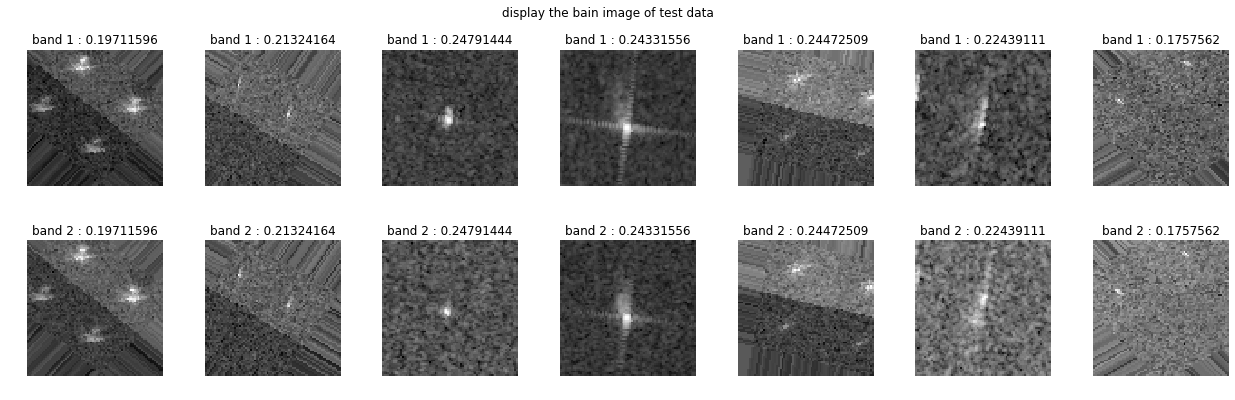

In [6]:
# Test Data Band 1 and Band 2 Image
band_1_test_data = np.array([np.array(data).astype(np.float32).reshape(75, 75, 1) for data in test_data['band_1']])
print ("band 1 shape :", band_1_test_data.shape)
band_2_test_data = np.array([np.array(data).astype(np.float32).reshape(75, 75, 1) for data in test_data['band_2']])
print ("band 2 shape :", band_2_test_data.shape)
angle_test_data = np.array(test_data['inc_angle']).reshape(-1, 1)
print ("angle shape :", angle_test_data.shape)
id_test_data = np.array(test_data['id'])
print ("id shape :", id_test_data.shape)

band_1_test_data, band_2_test_data, angle_test_data = normalization_data(band_1_test_data, band_2_test_data, angle_test_data, IS_ENABLE_NORMALIZATION)

del test_data
gc.collect()

display_ice_berg(band_1_test_data, band_2_test_data, angle_test_data, None, 200, suptitle = "display the bain image of test data")


# **三、使用資料增強 (data augmentation)的方法來增加訓練資料**

In [7]:
import math
import random
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator 

def data_generator(band_1, band_2, angle, is_ice_berg, batch_size, shuffle = True, sample_rate = 1.0, normalization = False, concatenate_img = True , reset_count = 100, is_augment = True):
    
    # 執行進行正規化的函式
    band_1, band_2, angle = normalization_data (band_1, band_2, angle, normalization)
    
    # 設定新增訓練影像的相關參數
    if is_augment:    
      band_augmentation = ImageDataGenerator(height_shift_range=[-8,8], width_shift_range=[-8,8], rotation_range=270)
    else:
      band_augmentation = ImageDataGenerator()
    
    # 每次取樣多少比例的總樣本進行訓練
    sample_data_len = (int) (is_ice_berg.shape[0] * sample_rate)
    
    # 依據批次訓練的樣本數計算最少需要的批次的次數
    batch_count = math.floor(sample_data_len / batch_size)
    
    # 實際可整除批次訓練數量的樣本數
    sample_data_len = batch_count * batch_size
    
    # 建立訓練資料的引索值        
    shuffle_data_index = np.arange(is_ice_berg.shape[0])
    
    #np.random.seed()  
    
    use_generate_data_count = 0       
    
    while True: 
      # 重新排列資料索引順序
      if shuffle:
          np.random.shuffle(shuffle_data_index)           
     
      # 依據批次訓練的數量reshape資料索引的格式
      data_index = shuffle_data_index[0:batch_size * batch_count].reshape(-1,batch_size)  
      
       # 針對band 1 及band 2進行影像處理的動作
      if use_generate_data_count <= 0:
        use_generate_data_count = reset_count
        random_seed = np.random.np.random.randint(0, 1024)
        band_1_augmentation = band_augmentation.flow(band_1, batch_size = band_1.shape[0], shuffle = False, seed = 23)
        band_2_augmentation = band_augmentation.flow(band_2, batch_size = band_2.shape[0], shuffle = False, seed = 23)  
        
        # 取出影像處理後的圖片
        band_1_augment_data = next(band_1_augmentation)
        band_2_augment_data = next(band_2_augmentation)
      else:   
        use_generate_data_count = use_generate_data_count - 1
      
      # 建立訓練的批次資料
      batch_band_1 = np.zeros(shape=(batch_size, band_1[0].shape[0], band_1[0].shape[1] ,1 ))
      batch_band_2 = np.zeros(shape=(batch_size, band_1[0].shape[0], band_1[0].shape[1] ,1 ))
      batch_band_3 = np.zeros(shape=(batch_size, band_1[0].shape[0], band_1[0].shape[1] ,1 ))
      batch_angle = np.zeros(shape=(batch_size,1))
      batch_is_iceberg = np.zeros(shape=(batch_size,1))
           
      for epoch_index in range(batch_count): 
        for i in range(2):
          if i == 0:
            # 依據打亂後的順序回傳未經過影像處理的訓練資料            
            for i, index in enumerate(data_index[epoch_index]):            
              batch_band_1[i]= band_1[index]      
              batch_band_2[i] = band_2[index]  
              batch_band_3[i] = np.maximum(batch_band_1[i], batch_band_2[i])
              batch_angle[i] = angle[index]
              batch_is_iceberg[i] = is_ice_berg[index]
          else:
            # 依據打亂後的順序回傳經過影像處理的訓練資料
            for i, index in enumerate(data_index[epoch_index]):            
              batch_band_1[i]= band_1_augment_data[index] 
              batch_band_2[i] = band_2_augment_data[index]
              batch_band_3[i] = np.maximum(batch_band_1[i], batch_band_2[i])
              batch_angle[i] = angle[index]
              batch_is_iceberg[i] = is_ice_berg[index]
            
          if concatenate_img:
            # band_concatenate = np.concatenate([batch_band_1, batch_band_2], axis=-1) 
            band_concatenate = np.concatenate([batch_band_1, batch_band_2, batch_band_3], axis=-1) 
            yield [band_concatenate, batch_angle], [batch_is_iceberg]
          else:
            yield [batch_band_1, batch_band_2, batch_angle], [batch_is_iceberg] 


Using TensorFlow backend.


In [0]:
try:
  del train_gen
  del valid_gen
except Exception:
  pass
finally:
  train_gen = data_generator(band_1_train_data, band_2_train_data, angle_train_data, is_iceberg_train_data, 16, normalization = IS_ENABLE_NORMALIZATION, shuffle=True, sample_rate = 1.0, concatenate_img = False) 
  valid_gen = data_generator(band_1_valid_data, band_2_valid_data, angle_valid_data, is_iceberg_valid_data, 64, normalization = IS_ENABLE_NORMALIZATION, shuffle=True, sample_rate = 1.0, concatenate_img = False)


[0.38227442] [0.37123311] [0.23286944] [0.]
[0.42321917] [0.39059919] [0.17430889] [1.]


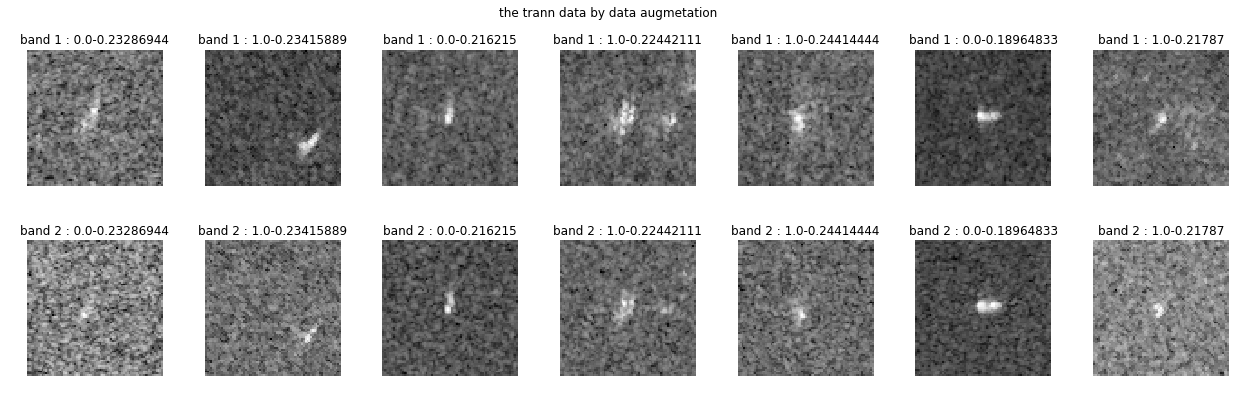

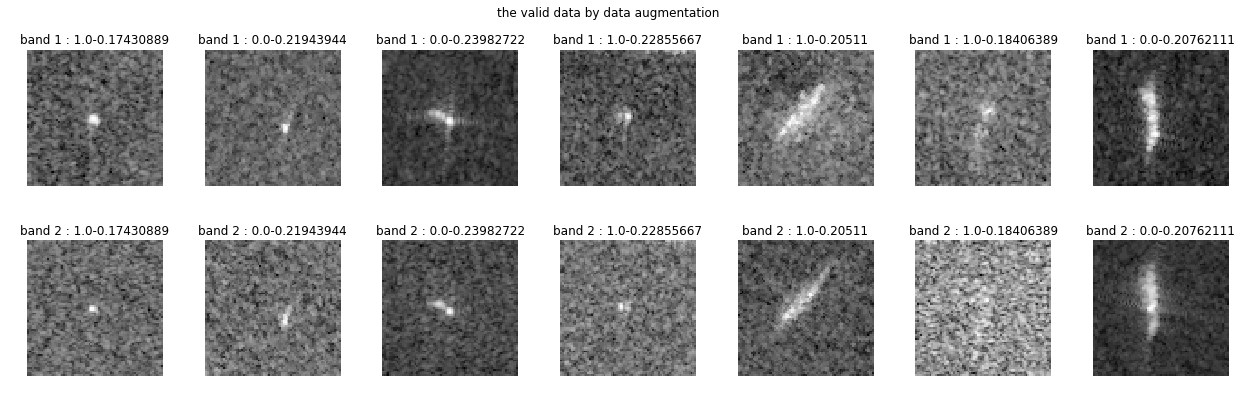

In [9]:
x, y = next(train_gen) 
#print (x[0][0][0][0])
print(x[0][0][0][0], x[1][0][0][0], x[2][0], y[0][0])
display_ice_berg(x[0], x[1], x[2], y[0], suptitle='the trann data by data augmetation')

x, y = next(valid_gen) 
print(x[0][0][0][0], x[1][0][0][0], x[2][0], y[0][0])
display_ice_berg(x[0], x[1], x[2], y[0], suptitle="the valid data by data augmentation")

# **四、建立訓練模型**

In [0]:
 
import keras.layers as KL
import keras.models as KM
import tensorflow as tf
#import keras.backend as K
import keras
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
 
def customized_model(connected_layer_style = 1, connected_node = 8):
  # 75 X 75
  input_image = keras.Input (shape=[IMAGE_WIDTH, IMAGE_HEIGHT, 3], dtype='float32') # image 

  x_11 = KL.Conv2D(16, (1, 1), padding='same', strides = 1, name='conv2d_lv1_11_1')(input_image)
  x_11 = KL.BatchNormalization()(x_11) 

  x_13 = KL.Conv2D(16, (3, 3), padding='same', strides = 1, name='conv2d_lv1_33_1')(input_image)
  x_13 = KL.BatchNormalization()(x_13)
 
  x_15 = KL.Conv2D(16, (5, 5), padding='same', strides = 1, name='conv2d_lv1_55_1')(input_image)
  x_15 = KL.BatchNormalization()(x_15)
  
  x =  KL.Concatenate()([x_11, x_13, x_15])  
  head = KL.Activation('relu')(x)  
  
  for i in range(4):
    x = KL.Conv2D(32, (1,1), padding='same', strides = 1) (head)
    x = KL.BatchNormalization()(x)
    x = KL.Activation('relu')(x)
  
    x = KL.Conv2D(connected_node, (3,3), padding='same', strides = (2,2))(x)
    x = KL.BatchNormalization()(x) 
 
    head = KL.Conv2D(connected_node, (1,1), padding='same', strides =(2,2)) (head)
    head = KL.BatchNormalization()(head)
  
    x = KL.Add()([x, head])
    head = KL.Activation('relu')(x)    
    head = KL.Dropout(0,5)(head)  
  
  if connected_layer_style == 1:   
    # 取每一个特征图的平均值作为输出，用以替代全连接层  
    x = KL.GlobalAveragePooling2D(name='glb_avg_pool')(head)  # shape=(?, 16) 
  elif connected_layer_style == 2: 
    x = KL.GlobalMaxPooling2D(name='glb_max_pool')(head)
  else:
    x = KL.Flatten()(head)    
    x = KL.Dense(connected_node, activation='relu')(x)
  
  input_angle = keras.Input (shape=[1], dtype='float32') # inc angle 

  angle_x = KL.Dense(connected_node, activation='relu')(input_angle)  
   
  # add angle  
  x = KL.Add()([x, angle_x])  

  merge_output = KL.Dense(1, activation='sigmoid')(x)

  model = KM.Model (inputs = [input_image, input_angle], outputs = [merge_output], name='predict_iceberg')
 
  optimizer_adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)

  #model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
  
  model.summary()
  return model
 

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
import keras.layers as KL

def use_classic_network(connected_node = 8 , use_model = 1):
  
  if use_model == 1:
    classic_net = ResNet50(include_top=False, input_tensor = None, weights="imagenet", input_shape= [IMAGE_HEIGHT , IMAGE_WIDTH, 3])
  else:
    classic_net = VGG16(include_top=False, input_tensor = None, weights="imagenet", input_shape=[IMAGE_HEIGHT , IMAGE_WIDTH, 3])
    
  x = classic_net.output
  x = KL.Flatten()(x)
  
  x = KL.Dropout(0.5)(x)
  x = KL.Dense(1024, activation='relu')(x)
  x = KL.Dropout(0.5)(x)  
  x = KL.Dense(connected_node, activation='relu')(x)
    
  input_angle = keras.Input (shape=[1], dtype='float32') # inc angle 

  angle_x = KL.Dense(connected_node, activation='relu')(input_angle)  
   
  # add angle  
  x = KL.Add()([x, angle_x])  
  
  merge_output = KL.Dense(1, activation='sigmoid')(x)

  model = KM.Model (inputs = [classic_net.input, input_angle], outputs = [merge_output], name='predict_iceberg')
 
  optimizer_adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.2)

  #model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
  
  model.summary()
  return model 


In [12]:
from keras.callbacks import ModelCheckpoint,CSVLogger, ReduceLROnPlateau, EarlyStopping

NAME = "ice_berg"

np.random.seed(2321)  

# load mode 

model = customized_model(connected_layer_style=1, connected_node=16)
 
#model = use_classic_network(use_model = 0)
  
log_dir = os.path.join( path.abspath("."), "log")

# Path to save after each epoch. Include placeholders that get filled by Keras.
save_model_path = os.path.join(log_dir, "{}_*epoch*_*loss*.h5".format(NAME.lower()))    
save_model_path = save_model_path.replace("*epoch*", "{epoch:04d}")
save_model_path = save_model_path.replace("*loss*", "{val_loss:04f}") 

save_log_path = os.path.join(log_dir, "{}_loss.csv".format(NAME.lower()))
if os.path.exists(save_log_path):
  os.remove(save_log_path)
  
#earlystop = EarlyStopping(monitor='val_loss', patience=50, mode='auto')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto', min_delta=0.001, cooldown=0, min_lr=0.00001)  
msave = ModelCheckpoint(save_model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False)
csv = CSVLogger(save_log_path, append=True)

train_gen = data_generator(band_1_train_data, band_2_train_data, angle_train_data, is_iceberg_train_data, 16, is_augment=True, \
                           normalization=IS_ENABLE_NORMALIZATION, shuffle=True, sample_rate = 1.0, concatenate_img = True) 
valid_gen = data_generator(band_1_valid_data, band_2_valid_data, angle_valid_data, is_iceberg_valid_data, 16, is_augment=True, \
                           normalization=IS_ENABLE_NORMALIZATION, shuffle=True, sample_rate = 1.0, concatenate_img = True)

model.fit_generator(
            train_gen ,
            initial_epoch = 0,
            epochs = 1000,
            steps_per_epoch= 100,
            callbacks = [csv, msave, reducelr], #earlystop
            validation_data = valid_gen,
            validation_steps = 20,
            max_queue_size = 100,
            workers = 0,
            use_multiprocessing=True)

del train_gen
del valid_gen

W0624 09:05:44.414353 140317753034624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 09:05:44.451431 140317753034624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 09:05:44.458173 140317753034624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 09:05:44.495481 140317753034624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 09:05:44.496579 1403177530

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_lv1_11_1 (Conv2D)        (None, 75, 75, 16)   64          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_lv1_33_1 (Conv2D)        (None, 75, 75, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_lv1_55_1 (Conv2D)        (None, 75, 75, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

# **五，載入訓練的最佳模型及分析結果**

In [0]:
# 設定模型的檔案路徑及載入模型
import os
from keras.models import load_model
#FILE_NAME = "keep/ice_berg_0368_0.212844"
FILE_NAME = "ice_berg_0249_0.258269"
model_path = os.path.join(path.abspath('.'),"log/{}.h5".format(FILE_NAME))

if not path.exists(model_path):   
    print (model_path)    
    raise ValueError ("File is not exists. - {}".format(model_path))

predict_model = load_model(model_path)
predict_model.summary()


W0624 03:14:26.787778 140293486684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 03:14:26.839555 140293486684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 03:14:26.901917 140293486684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 03:14:26.902918 140293486684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 03:14:26.904836 140293486

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_lv1_11_1 (Conv2D)        (None, 75, 75, 16)   64          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_lv1_33_1 (Conv2D)        (None, 75, 75, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_lv1_55_1 (Conv2D)        (None, 75, 75, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

from sklearn.metrics import roc_curve, auc

def display_roc_curve(predict_result, target_result, caption="Receiver Operating Characteristic Curve"):  
  fpr, tpr, _ = roc_curve(target_result, predict_result)   
  label_list = "area under curve :{}".format(round(auc(fpr, tpr),2))
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange',lw=2, label= label_list) 
  plt.plot([0.0,1],[0,1], color='navy',lw=2)   
  plt.xlim([0.0, 1.0])  # 設定X軸的刻度
  plt.ylim([0.0, 1.02]) # 設定Y軸的刻度且為了避免1.0的線與圖的外框相連，因此多出0.02
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(caption)
  plt.legend(loc='lower right') # 設定線段說明的位置
  plt.show()


def display_mulit_roc_curve(dictargs, caption ):  
    plt.figure()
    plt.plot([0.0,1],[0,1], color='navy',lw=2)   
    plt.xlim([0.0, 1.0])  # 設定X軸的刻度
    plt.ylim([0.0, 1.02]) # 設定Y軸的刻度且為了避免1.0的線與圖的外框相連，因此多出0.02
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
     
    line_color=['darkorange', 'black', 'green', "black", "red", "cyan", "yellow", "magenta"]
    
    for i, key in enumerate(dictargs):
      val = dictargs.get(key)     
      fpr, tpr, _ = roc_curve(val[0], val[1])
      roc_auc = round(auc(fpr, tpr),2)      
      plt.plot(fpr, tpr, color=line_color[i], lw=2, label= "{} auc :{}".format(key,roc_auc)) 
      
    plt.legend(loc='lower right')  
    plt.show()
    
def display_error_image(band_1, band_2, angle, target, predict, display_index, suptitle ="diisplay error image" ):  
  fig, ax = plt.subplots(figsize=(22 , 6))
  fig.subplots_adjust(hspace=0.4, wspace=0.1)   
 
  for i, index in enumerate(display_index):
    if (i >= DISPLAY_IMAGE): break;
    plt.subplot(2, DISPLAY_IMAGE, i + 1)       
    plt.title("band 1:{}-{:.8f}\nangle:{:.8f}".format(target[index][0], predict[index][0], angle[index][0]))
    plt.axis("off")
    plt.imshow(band_1[index].reshape(75,75), cmap="gray")
   
  for i, index in enumerate(display_index): 
    if (i >= DISPLAY_IMAGE): break;
    plt.subplot(2, DISPLAY_IMAGE, i + DISPLAY_IMAGE + 1)      
    plt.title("band 2:{}-{:.8f}\nangle:{:.8f}".format(target[index][0], predict[index][0], angle[index][0] )) 
    plt.axis("off")
    plt.suptitle = suptitle
    plt.imshow(band_2[index].reshape(75,75), cmap="gray")
  

=== Train Dataset ===
1271/1271 [==============================] - 1s 552us/step
loss :  0.08979732689193437
accuracy : 0.982690794649882
=== Validation Dataset ===
200/200 [==============================] - 0s 251us/step
loss :  0.28032473266124724
accuracy : 0.895


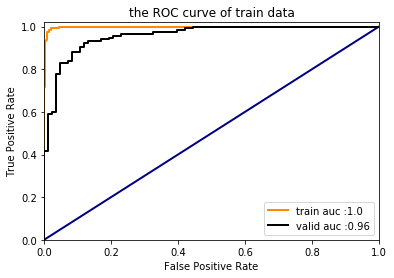

In [0]:
# 評估模型
roc_dict ={}
# 評估Train Dataset的loss值及正確率
print ("=== Train Dataset ===")
band_1, band_2, angle = normalization_data(band_1_train_data, band_2_train_data, angle_train_data, IS_ENABLE_NORMALIZATION)
band_3 = np.maximum(band_1, band_2)
band = np.concatenate((band_1, band_2, band_3) ,axis = -1)
predict = predict_model.predict(x=[band, angle])
roc_dict["train"] = (is_iceberg_train_data, predict)
train_data_result = predict_model.evaluate(x=[band, angle], y = is_iceberg_train_data)
print ("loss : ", train_data_result[0])
print ("accuracy :", train_data_result[1])

# 評估Validation Dataset的loss值及正確率
print ("=== Validation Dataset ===")
band_1, band_2, angle = normalization_data(band_1_valid_data, band_2_valid_data, angle_valid_data, IS_ENABLE_NORMALIZATION)
band_3 = np.maximum(band_1, band_2)
band = np.concatenate((band_1,band_2, band_3) ,axis = -1)   
  
predict = predict_model.predict(x=[band, angle])
roc_dict["valid"] = (is_iceberg_valid_data, predict)
valid_data_result = predict_model.evaluate(x= [band, angle], y = is_iceberg_valid_data)
print ("loss : ", valid_data_result[0])
print ("accuracy :", valid_data_result[1])
                                        
                                               
# 建立ROC Curve (Receiver Operating Characteristic Curve)
display_mulit_roc_curve(roc_dict, caption="the ROC curve of train data")

In [0]:
import seaborn as sn  
from sklearn.metrics import classification_report, confusion_matrix
 
target_names = ['non-iceberg', 'icebert' ]
 
print ("=== the confusion matrix of train data ====")
iceberg_classify = [0 if prob[0] < 0.5 else 1 for prob in roc_dict["train"][1]]      
cm = confusion_matrix(y_true=is_iceberg_train_data, y_pred=iceberg_classify)
print(pd.DataFrame(cm, columns=target_names))
print(classification_report(is_iceberg_train_data, iceberg_classify, target_names=target_names)) 
  
print ("=== the confusion matrix of valid data ====") 
iceberg_classify = [0 if prob[0] < 0.5 else 1 for prob in roc_dict["valid"][1]]
cm = confusion_matrix(y_true=is_iceberg_valid_data, y_pred=iceberg_classify)
print (pd.DataFrame(cm, columns=target_names))
print (classification_report(is_iceberg_valid_data, iceberg_classify, target_names=target_names)) 


=== the confusion matrix of train data ====
   non-iceberg  icebert
0          624       11
1           11      625
              precision    recall  f1-score   support

 non-iceberg       0.98      0.98      0.98       635
     icebert       0.98      0.98      0.98       636

    accuracy                           0.98      1271
   macro avg       0.98      0.98      0.98      1271
weighted avg       0.98      0.98      0.98      1271

=== the confusion matrix of valid data ====
   non-iceberg  icebert
0           74        9
1           12      105
              precision    recall  f1-score   support

 non-iceberg       0.86      0.89      0.88        83
     icebert       0.92      0.90      0.91       117

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200



In [0]:
# 顯示錯誤的資料
non_iceberg_false = []
iceberg_false = []
for i, result in enumerate(zip(is_iceberg_valid_data, iceberg_classify)):  
  if result[0] != result[1]:
      if result[0] == 1:
        iceberg_false.append(i) 
      else: 
        non_iceberg_false.append(i) 
        
display_error_image(band_1_train_data, band_2_train_data, angle_valid_data, is_iceberg_valid_data, roc_dict["valid"][1], iceberg_false, suptitle="Iceberg False Image")
display_error_image(band_1_train_data, band_2_train_data, angle_valid_data, is_iceberg_valid_data, roc_dict["valid"][1], non_iceberg_false, suptitle="Non-Iceberg False Image")

=== Test Dataset ===
=== Round 1 ===
200/200 [==============================] - 0s 352us/step
loss :  0.2803247421979904
accuracy : 0.895
=== Round 2 ===
200/200 [==============================] - 0s 327us/step
loss :  0.40660991668701174
accuracy : 0.805
=== Round 3 ===
200/200 [==============================] - 0s 311us/step
loss :  0.28032474517822265
accuracy : 0.895
=== Round 4 ===
200/200 [==============================] - 0s 290us/step
loss :  0.4066098976135254
accuracy : 0.805
=== Round 5 ===
200/200 [==============================] - 0s 296us/step
loss :  0.280324741601944
accuracy : 0.895
=== Round 6 ===
200/200 [==============================] - 0s 290us/step
loss :  0.40660991191864015
accuracy : 0.805
=== Round 7 ===
200/200 [==============================] - 0s 275us/step
loss :  0.280324739664793
accuracy : 0.895
=== Round 8 ===
200/200 [==============================] - 0s 289us/step
loss :  0.40660990357398985
accuracy : 0.805
=== Average evaluate ===
loss :  0.343467

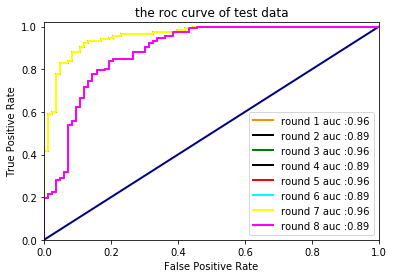

In [0]:
# 使用資料增強的方式產生Test Dataset進行評估loss值及正確率
print ("=== Test Dataset ===")
TEST_ECPOHS = 8

test_gen = data_generator(band_1_valid_data , band_2_valid_data , angle_valid_data , is_iceberg_valid_data, 200, reset_count=1,\
                          shuffle = True, normalization = IS_ENABLE_NORMALIZATION,  sample_rate=1.0, concatenate_img=True)
Average_Loss = 0
Average_Accuracy = 0
roc_dict ={}
total_predict = []
total_target = []
for i in range (TEST_ECPOHS):
  print ("=== Round {} ===".format(i+1))  
  test_data , test_ans = next(test_gen)   
  total_target.extend(test_ans[0])
 
  # 使用predict方法取得判斷的機率值並存至roc_dict字典物件
  predict_result = predict_model.predict(x=[test_data[0], test_data[1]])
  total_predict.extend(predict_result)
  key = "round {}".format(i+1)
  roc_dict[key] = (test_ans[0], predict_result)
  
  # 使用predict方法取得判斷的機率值
  predict_result = predict_model.evaluate(x=[test_data[0], test_data[1]], y=test_ans)  
  print ("loss : ", predict_result[0])
  print ("accuracy :", predict_result[1])
  
  Average_Loss += predict_result[0]
  Average_Accuracy += predict_result[1]

print ("=== Average evaluate ===")
print ("loss : ", Average_Loss / TEST_ECPOHS)
print ("accuracy :",Average_Accuracy / TEST_ECPOHS)

# 建立ROC Curve (Receiver Operating Characteristic Curve)
display_mulit_roc_curve(roc_dict, caption="the roc curve of test data")



In [0]:
import seaborn as sn  
from sklearn.metrics import classification_report, confusion_matrix 
target_names = ['non-iceberg', 'icebert' ] 
print ("=== the confusion matrix of test data ====")
iceberg_classify = [0 if prob[0] < 0.5 else 1  for prob in total_predict ] 
confusion_matrix = confusion_matrix(y_true=total_target, y_pred=iceberg_classify)
print(pd.DataFrame(confusion_matrix, columns=target_names))
print(classification_report(total_target, iceberg_classify, target_names=target_names)) 
 

=== the confusion matrix of test data ====
   non-iceberg  icebert
0          544      120
1          120      816
              precision    recall  f1-score   support

 non-iceberg       0.82      0.82      0.82       664
     icebert       0.87      0.87      0.87       936

    accuracy                           0.85      1600
   macro avg       0.85      0.85      0.85      1600
weighted avg       0.85      0.85      0.85      1600



# **六，產生上傳的Submisson檔案**

In [0]:
import datetime
save_file = "ice_berg_submission_{:%Y%m%d_%H%M}.csv".format(datetime.datetime.now())
print (save_file)
band_3 = np.maximum(band_1_test_data, band_2_test_data)
band = np.concatenate((band_1_test_data,band_2_test_data, band_3) ,axis = -1)

predict_result = predict_model.predict(x=[band, angle_test_data])

save_result = pd.DataFrame()
save_result['id'] = id_test_data.reshape(-1)
save_result['is_iceberg'] = predict_result
save_result.to_csv(save_file, index=False)
print(save_result.head())

ice_berg_submission_20190624_0338.csv
         id  is_iceberg
0  5941774d    0.275987
1  4023181e    0.295818
2  b20200e4    0.000000
3  e7f018bb    0.819459
4  4371c8c3    0.000043


In [0]:
from keras.utils.vis_utils import plot_model

# Create model object in inference mode. inference training
plot_model(model, to_file="iceberg.png", show_shapes=True, show_layer_names=True)